# Global Trade Network Simulation

This notebook simulates international trade relationships between countries as a dynamic network. The simulation models:

- **Friendship relationships** between countries (ranging from 0 to 1)
- **Tariffs** applied to trade between countries (inversely related to friendship)
- **Transaction costs** for trade between countries

The simulation demonstrates how trade relationships evolve over time based on interaction patterns, showing the emergence of trade communities and the effects of economic policies.

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns

# For community detection
try:
    from community import community_louvain
except ImportError:
    print("Installing community detection package...")
    !pip install python-louvain
    try:
        from community import community_louvain
    except ImportError:
        print("Could not import community_louvain - community detection functionality will be limited")

# Initialize the global trade network
np.random.seed(42)  # For reproducibility
num_countries = 193
countries = [f"Country_{i}" for i in range(num_countries)]

# Create a directed graph to represent trade relationships
G = nx.DiGraph()
G.add_nodes_from(countries)

# Initialize random friendship strengths (0-1) between countries
friendship_matrix = np.random.random((num_countries, num_countries)) * 0.5 + 0.5  # Values between 0.5 and 1
friendship_threshold = 0.2  # Below this, trade relationship breaks

# Make friendship symmetric and set diagonal to 1 (self-friendship)
friendship_matrix = (friendship_matrix + friendship_matrix.T) / 2
np.fill_diagonal(friendship_matrix, 1.0)

# Initial trade connections - not all countries have direct trade
connection_probability = 0.05  # Sparse initial connections
for i in range(num_countries):
    for j in range(num_countries):
        if i != j and np.random.random() < connection_probability:
            # Add edge with base transaction cost and tariff based on friendship
            tariff = 1.0 - friendship_matrix[i, j]**2  # Friendship strongly reduces tariff
            
            # Generate a random distance factor (representing geographic distance)
            distance = np.random.random() * 10  # Random distance between 0-10 units
            
            # Add edge with all attributes
            G.add_edge(countries[i], countries[j], 
                      friendship=friendship_matrix[i, j],
                      tariff=tariff,
                      distance=distance,
                      transaction_cost=0.05 + 0.1 * np.random.random())  # Base transaction cost

# Function to update the network for each simulation step
def update_network(G, friendship_matrix, step):
    # 1. Trade affects friendship
    for u, v, data in list(G.edges(data=True)):
        i = countries.index(u)
        j = countries.index(v)
        
        # Tariffs reduce friendship
        friendship_matrix[i, j] -= data['tariff'] * 0.01
        friendship_matrix[j, i] = friendship_matrix[i, j]  # Keep symmetric
        
        # Update friendship in the graph
        data['friendship'] = friendship_matrix[i, j]
        
        # Update tariff based on new friendship
        data['tariff'] = 1.0 - friendship_matrix[i, j]**2
        
        # Remove edge if friendship falls below threshold
        if friendship_matrix[i, j] < friendship_threshold:
            G.remove_edge(u, v)
    
    # 2. Random new trade connections emerge
    if step % 5 == 0:  # Every 5 steps
        for _ in range(int(num_countries * 0.02)):  # 2% of countries form new connections
            i = np.random.randint(0, num_countries)
            j = np.random.randint(0, num_countries)
            if i != j and not G.has_edge(countries[i], countries[j]):
                # New trade relationship based on current friendship
                tariff = 1.0 - friendship_matrix[i, j]**2
                distance = np.random.random() * 10  # Random distance between 0-10 units
                G.add_edge(countries[i], countries[j],
                          friendship=friendship_matrix[i, j],
                          tariff=tariff,
                          distance=distance,
                          transaction_cost=0.05 + 0.1 * np.random.random())
    
    # 3. Ensure friendship stays in valid range [0,1]
    friendship_matrix = np.clip(friendship_matrix, 0, 1)
    
    return G, friendship_matrix

# Function to visualize the network
def plot_network(G):
    plt.figure(figsize=(12, 10))
    
    # Use friendship as edge weight for visualization
    edge_weights = [G[u][v]['friendship']*3 for u, v in G.edges()]
    
    # Color edges based on tariffs (red=high tariff, green=low tariff)
    edge_colors = [plt.cm.RdYlGn(1-G[u][v]['tariff']) for u, v in G.edges()]
    
    # Layout with weighted edges
    pos = nx.spring_layout(G, weight='friendship', k=0.2, seed=42)  # Add seed for reproducibility
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=30, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color=edge_colors, 
                          arrowsize=5, connectionstyle="arc3,rad=0.1")
    
    plt.title(f"Global Trade Network - {G.number_of_edges()} trade relationships")
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

# Simulation function for animation
def simulate(num_steps=100):
    global G, friendship_matrix
    
    stats = {
        'steps': [],
        'num_edges': [],
        'avg_friendship': [],
        'avg_tariff': []
    }
    
    for step in range(num_steps):
        G, friendship_matrix = update_network(G, friendship_matrix, step)
        
        # Collect statistics
        if step % 5 == 0:
            stats['steps'].append(step)
            stats['num_edges'].append(G.number_of_edges())
            
            if G.number_of_edges() > 0:
                avg_friendship = np.mean([G[u][v]['friendship'] for u, v in G.edges()])
                avg_tariff = np.mean([G[u][v]['tariff'] for u, v in G.edges()])
                stats['avg_friendship'].append(avg_friendship)
                stats['avg_tariff'].append(avg_tariff)
            else:
                stats['avg_friendship'].append(0)
                stats['avg_tariff'].append(0)
    
    return stats


## Basic Network Simulation and Visualization

Below, we run a 100-step simulation of the global trade network and visualize the results. The simulation shows:

1. The network graph of trade relationships between countries
2. The evolution of the number of trade relationships over time
3. Changes in average friendship and tariff levels

As the simulation progresses, countries with stronger friendships maintain lower tariffs, while countries with weaker relationships may lose trade connections entirely.

In [15]:
# Run a short simulation and visualize results
def run_and_visualize(num_steps=100):
    stats = simulate(num_steps)
    
    # Create a figure with proper spacing
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('Global Trade Network Simulation Results', fontsize=16)
    
    # Add subplot for network visualization
    ax1 = fig.add_subplot(2, 1, 1)
    # Get network figure and display in the right subplot
    network_fig = plot_network(G)
    plt.close(network_fig)  # Close the separate figure
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title(f"Global Trade Network - {G.number_of_edges()} relationships")
    ax1.axis('off')
    
    # Add subplot for edge count over time
    ax2 = fig.add_subplot(2, 2, 3)
    ax2.plot(stats['steps'], stats['num_edges'], 'b-', linewidth=2)
    ax2.set_title('Number of Trade Relationships')
    ax2.set_xlabel('Simulation Steps')
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    
    # Add subplot for friendship and tariff
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(stats['steps'], stats['avg_friendship'], 'g-', linewidth=2, label='Avg Friendship')
    ax3.plot(stats['steps'], stats['avg_tariff'], 'r-', linewidth=2, label='Avg Tariff')
    ax3.set_title('Trade Relationship Metrics')
    ax3.set_xlabel('Simulation Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()
    
    # Print summary statistics
    if G.number_of_edges() > 0:
        print(f"\nSummary Statistics after {num_steps} steps:")
        print(f"  - Final number of trade relationships: {G.number_of_edges()}")
        print(f"  - Average friendship level: {stats['avg_friendship'][-1]:.4f}")
        print(f"  - Average tariff level: {stats['avg_tariff'][-1]:.4f}")
        
        # Calculate network density
        density = nx.density(G)
        print(f"  - Network density: {density:.4f}")
        
        # Calculate reciprocity (proportion of bilateral trade relationships)
        reciprocity = nx.reciprocity(G)
        print(f"  - Trade reciprocity: {reciprocity:.4f}")
    else:
        print("No trade relationships remain after the simulation.")

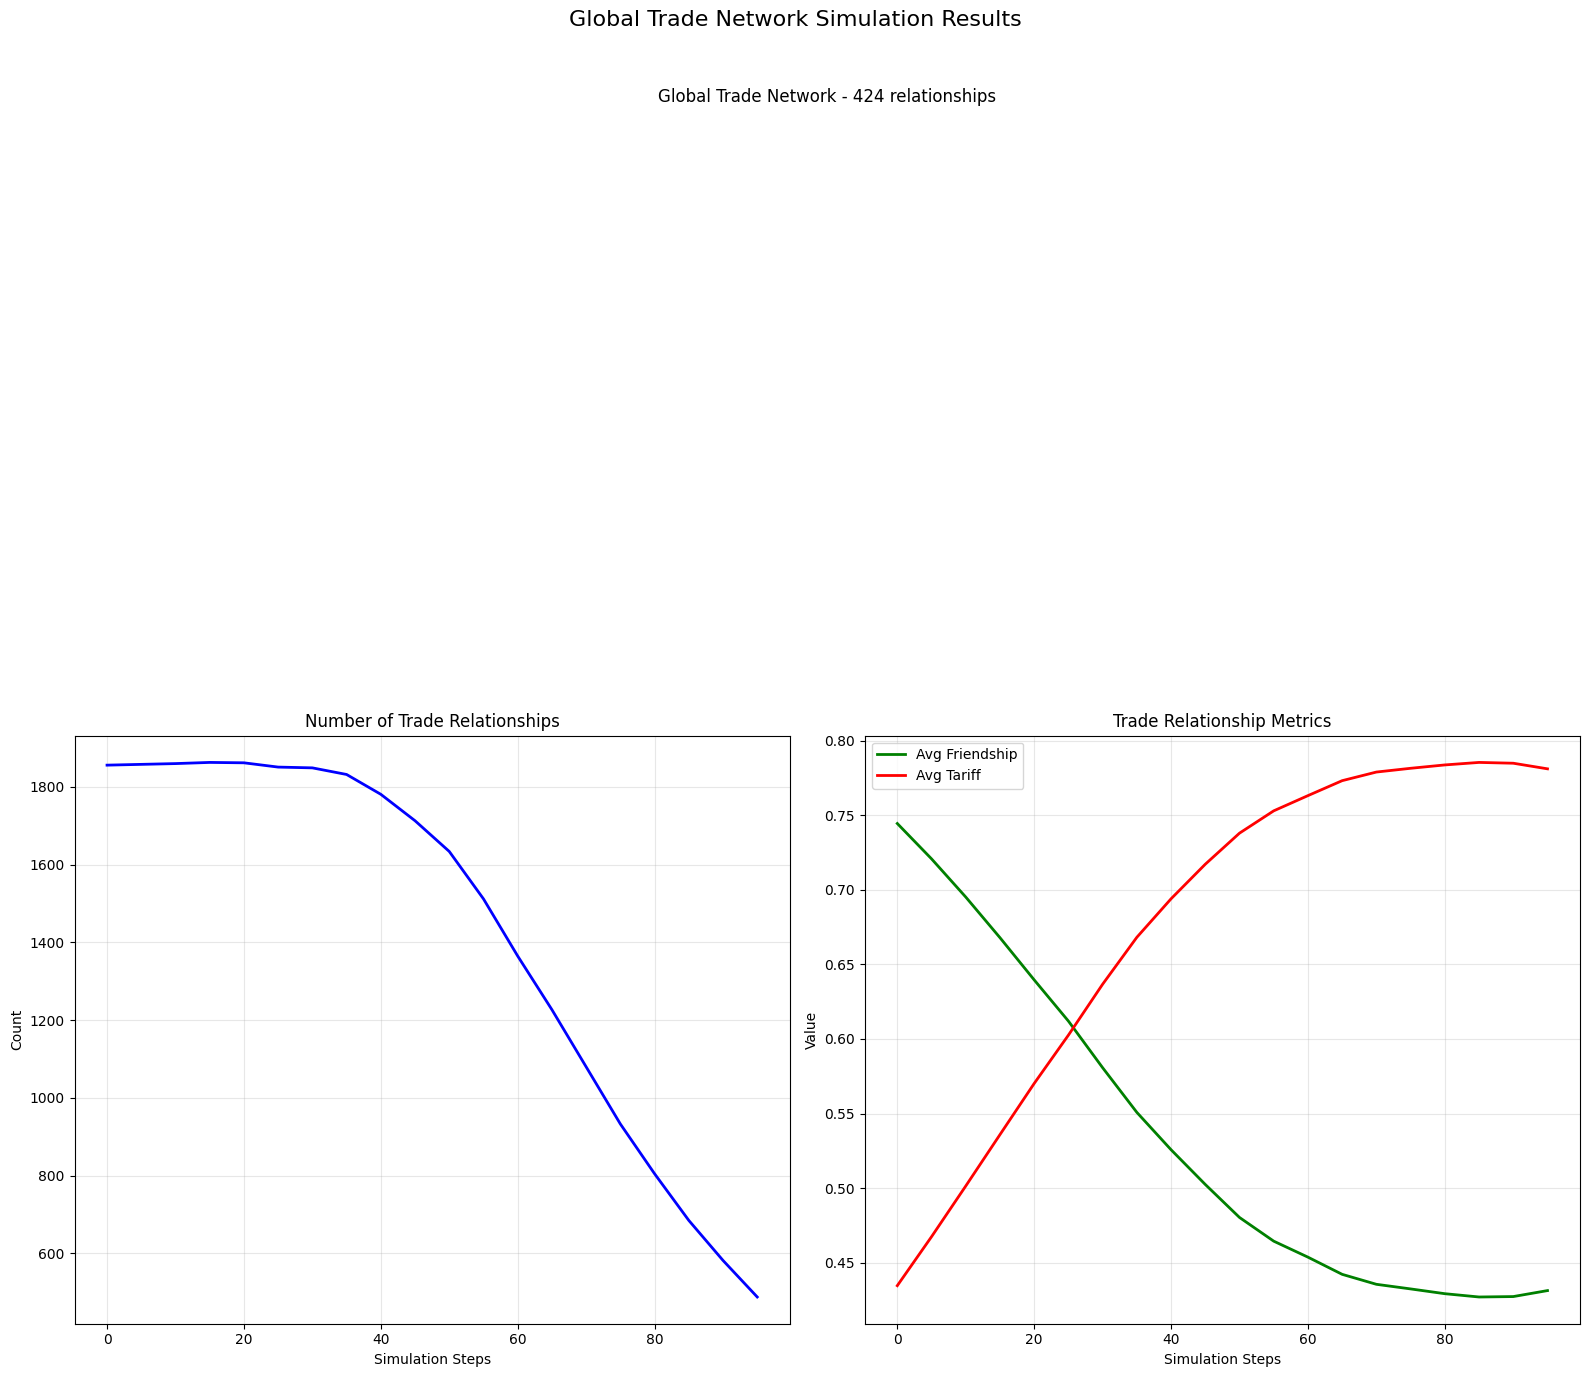


Summary Statistics after 100 steps:
  - Final number of trade relationships: 424
  - Average friendship level: 0.4312
  - Average tariff level: 0.7812
  - Network density: 0.0114
  - Trade reciprocity: 0.0000


In [16]:
run_and_visualize(100)

## Analyzing Geographic Distance Effects

Distance plays a crucial role in international trade. Countries that are geographically closer tend to trade more frequently and with lower transaction costs. In our simulation, we explore the relationship between:

- Geographic distance between countries
- Transaction costs of trade
- Tariff levels

The analysis below shows how distance correlates with these economic factors.

In [17]:
# Analyze the relationship between distance and transaction cost
def analyze_distance_effect():
    if G.number_of_edges() > 0:
        # Safely extract edge attributes
        edges_data = []
        for u, v, data in G.edges(data=True):
            # Check if all required attributes exist
            if all(attr in data for attr in ['distance', 'transaction_cost', 'tariff', 'friendship']):
                edges_data.append({
                    'Distance': data['distance'],
                    'Transaction Cost': data['transaction_cost'],
                    'Tariff': data['tariff'],
                    'Friendship': data['friendship']
                })
        
        # Create DataFrame for analysis
        if edges_data:
            df = pd.DataFrame(edges_data)
            
            # Set up a nice style for the plots
            sns.set_style('whitegrid')
            
            # Create a figure with multiple subplots
            fig = plt.figure(figsize=(16, 12))
            fig.suptitle('Impact of Geographic Distance on Trade Relationships', fontsize=16)
            
            # Plot 1: Distance vs. Transaction Cost
            ax1 = fig.add_subplot(2, 2, 1)
            sns.scatterplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, alpha=0.6)
            sns.regplot(x='Distance', y='Transaction Cost', data=df, ax=ax1, scatter=False, color='red')
            ax1.set_title('Distance vs. Transaction Cost')
            
            # Plot 2: Distance vs. Tariff
            ax2 = fig.add_subplot(2, 2, 2)
            sns.scatterplot(x='Distance', y='Tariff', data=df, ax=ax2, alpha=0.6)
            sns.regplot(x='Distance', y='Tariff', data=df, ax=ax2, scatter=False, color='red')
            ax2.set_title('Distance vs. Tariff')
            
            # Plot 3: Distance vs. Friendship
            ax3 = fig.add_subplot(2, 2, 3)
            sns.scatterplot(x='Distance', y='Friendship', data=df, ax=ax3, alpha=0.6)
            sns.regplot(x='Distance', y='Friendship', data=df, ax=ax3, scatter=False, color='red')
            ax3.set_title('Distance vs. Friendship')
            
            # Plot 4: Transaction Cost vs. Tariff
            ax4 = fig.add_subplot(2, 2, 4)
            sns.scatterplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, alpha=0.6)
            sns.regplot(x='Transaction Cost', y='Tariff', data=df, ax=ax4, scatter=False, color='red')
            ax4.set_title('Transaction Cost vs. Tariff')
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
            plt.show()
            
            # Calculate correlations
            print("Correlation Analysis:")
            corr_matrix = df.corr()
            print(corr_matrix.round(4))
            
            # Calculate average transaction costs by distance quartiles
            print("\nTransaction Costs by Distance Quartile:")
            df['Distance Quartile'] = pd.qcut(df['Distance'], 4, labels=['Q1 (Closest)', 'Q2', 'Q3', 'Q4 (Farthest)'])
            quartile_stats = df.groupby('Distance Quartile').agg({
                'Transaction Cost': 'mean',
                'Tariff': 'mean',
                'Friendship': 'mean'
            })
            
            print(quartile_stats.round(4))
        else:
            print("Graph edges don't have the required attributes (distance, transaction_cost, tariff).")
    else:
        print("No edges in the network to analyze.")

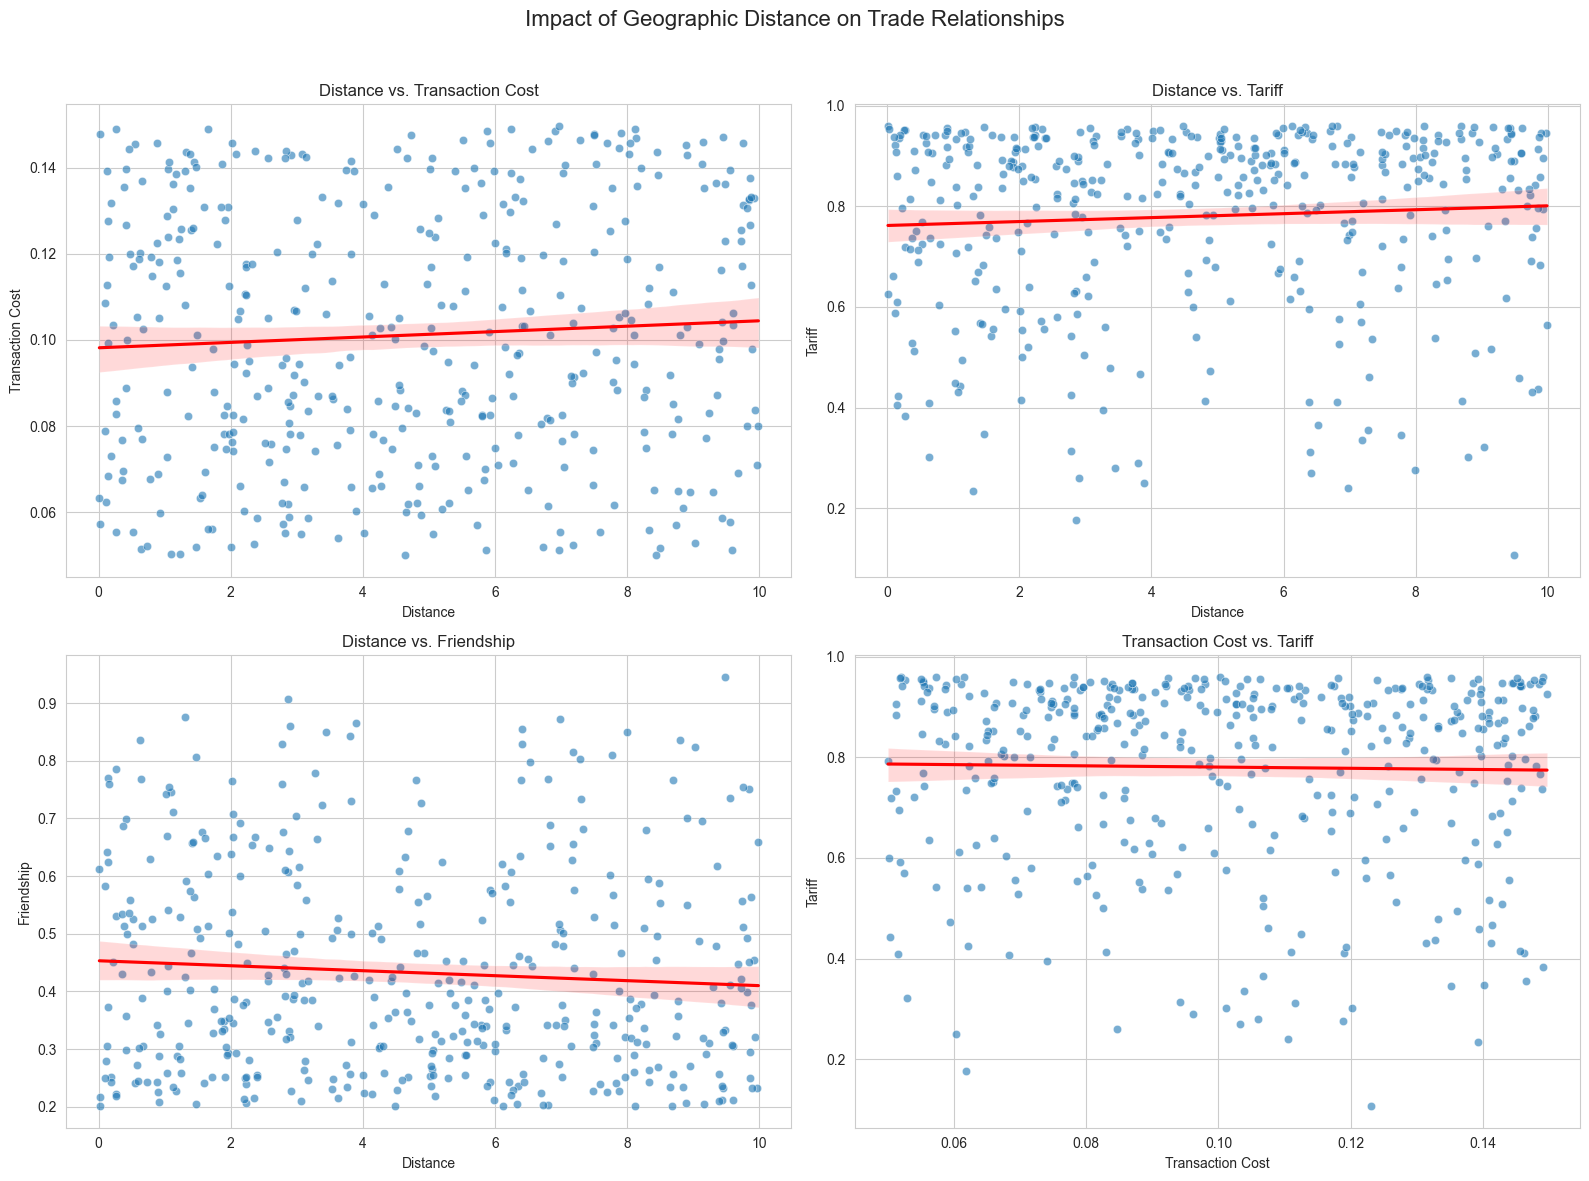

Correlation Analysis:
                  Distance  Transaction Cost  Tariff  Friendship
Distance            1.0000            0.0631  0.0635     -0.0711
Transaction Cost    0.0631            1.0000 -0.0196      0.0144
Tariff              0.0635           -0.0196  1.0000     -0.9838
Friendship         -0.0711            0.0144 -0.9838      1.0000

Transaction Costs by Distance Quartile:
                   Transaction Cost  Tariff  Friendship
Distance Quartile                                      
Q1 (Closest)                 0.1025  0.7572      0.4571
Q2                           0.0951  0.7727      0.4407
Q3                           0.1010  0.8016      0.4119
Q4 (Farthest)                0.1060  0.7897      0.4209


/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_45789/471213971.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = df.groupby('Distance Quartile').agg({


In [18]:
analyze_distance_effect()

## Trade Communities and Blocs Analysis

In the global trade network, countries often form natural trading communities or blocs based on their relationships. These communities may represent regional trade agreements, cultural similarities, or strategic alliances.

Below, we use community detection algorithms to identify these natural trading communities in our simulated network. This analysis can reveal:

- The number of distinct trading blocs
- The size and influence of each community
- The overall modularity of the network (how well-defined the communities are)

In [22]:
def visualize_communities():
    if G.number_of_edges() > 0:
        G_undir = G.to_undirected()

        try:
            # Calculate node positions with a more stable layout
            pos = nx.spring_layout(G_undir, seed=42, k=0.2, iterations=100)

            # Method 1: Louvain community detection if available
            try:
                from community import community_louvain
            except ImportError:
                raise ImportError("community_louvain module not available")

            # Detect communities
            partition = community_louvain.best_partition(G_undir)

            # Prepare figure
            plt.figure(figsize=(14, 10))

            # Count communities
            communities = set(partition.values())
            num_communities = len(communities)

            # Color nodes by community
            cmap = plt.cm.get_cmap('viridis', num_communities)

            # Draw nodes colored by community
            for com in communities:
                com_nodes = [node for node in partition if partition[node] == com]
                nx.draw_networkx_nodes(
                    G_undir, pos, com_nodes,
                    node_size=40,
                    node_color=[cmap(com)] * len(com_nodes),
                    label=f"Community {com}"
                )

            nx.draw_networkx_edges(G_undir, pos, alpha=0.2, width=0.5)
            plt.title(f"Trade Network Communities (Louvain Method) - {num_communities} communities detected")
            plt.axis('off')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, fontsize=8, loc='upper right')
            plt.tight_layout()
            plt.show()

            # Community statistics
            community_sizes = {}
            for com in communities:
                size = sum(1 for node in partition if partition[node] == com)
                community_sizes[f"Community {com}"] = size

            sizes_df = pd.DataFrame(list(community_sizes.items()), columns=['Community', 'Size'])
            sizes_df = sizes_df.sort_values('Size', ascending=False).reset_index(drop=True)

            plt.figure(figsize=(12, 6))
            ax = sns.barplot(x='Community', y='Size', data=sizes_df.head(15))
            plt.title('Top 15 Community Sizes')
            plt.xticks(rotation=45)

            for i, p in enumerate(ax.patches):
                if i < len(sizes_df.head(15)):
                    ax.annotate(
                        str(int(p.get_height())),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom'
                    )

            plt.tight_layout()
            plt.show()

            print(f"Detected {num_communities} communities in the trade network.")
            print(f"Modularity of the partition: {community_louvain.modularity(partition, G_undir):.4f}")
            print(f"Largest community size: {sizes_df['Size'].max()} countries")
            print(f"Smallest community size: {sizes_df['Size'].min()} countries")

        except (NameError, ImportError):
            print("Louvain community detection not available, using alternative method...")
            from networkx.algorithms.community import greedy_modularity_communities
            fallback_communities = list(greedy_modularity_communities(G_undir))
            print(f"Detected {len(fallback_communities)} communities using a greedy modularity approach.")
    else:
        print("No edges remain in the network.")

/var/folders/cd/vmj840453cz603ygrc6my4300000gn/T/ipykernel_45789/3885934602.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_communities)


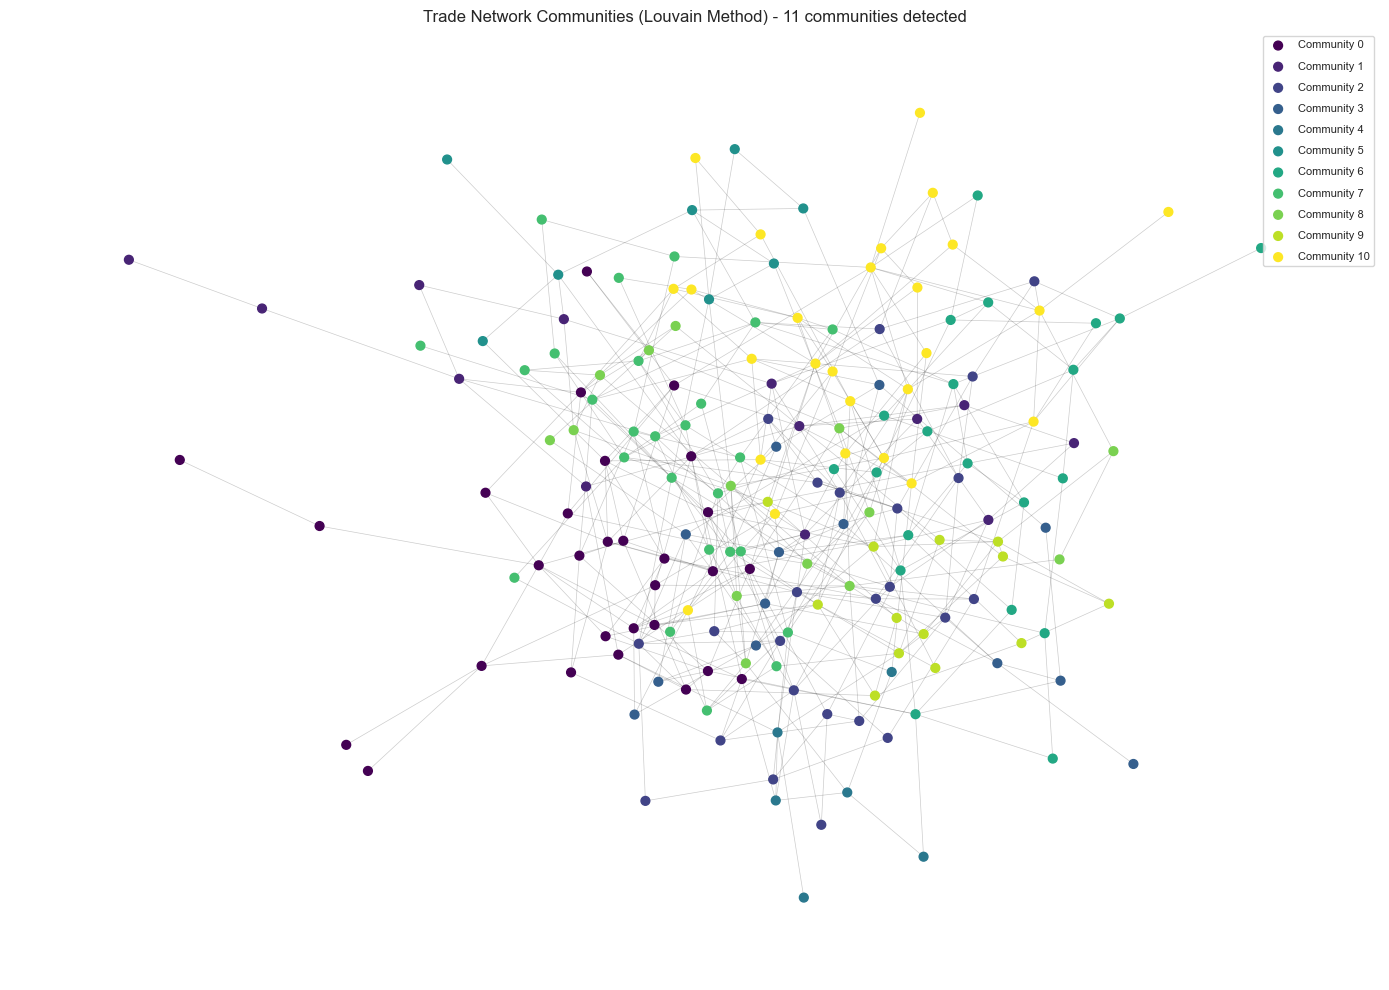

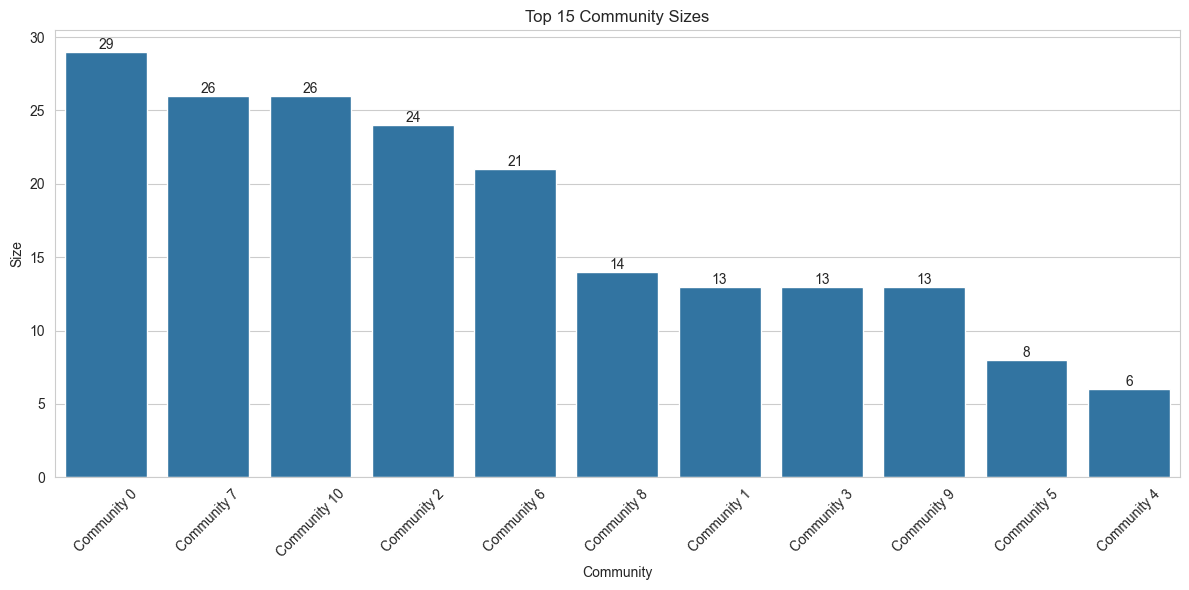

Detected 11 communities in the trade network.
Modularity of the partition: 0.4836
Largest community size: 29 countries
Smallest community size: 6 countries


In [23]:
visualize_communities()